In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table


In [3]:
fast = np.loadtxt('data/epics_fast.txt')
slow = np.loadtxt('data/epics_slow.txt')
superfast = np.loadtxt('data/epics_superfast.txt')

In [4]:
from astropy.stats import mad_std

In [5]:
from astropy.stats import LombScargle

In [6]:
douglas = Table.read('data/douglas2017.vot')
douglas.add_index('EPIC')

In [7]:
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize
from scipy.signal import argrelmax
from interpacf import interpolated_acf

In [19]:
plots = False
smoothed_amps_fast = dict()
newstat_fast = dict()
periods = dict()

baseline_flux_at_flares = []
smoothed_flux_dist = []

for i in range(len(fast)): 
    times, fluxes = np.load("data/{0}.npy".format(int(fast[i])))
    clipped = ~np.isnan(fluxes)
    times, fluxes = times[clipped], fluxes[clipped]
    clip_flares = np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)

    # Remove polynomial trend
    fit = np.polyval(np.polyfit(times[clip_flares]-times.mean(), fluxes[clip_flares], 5), times-times.mean())
    fluxes /= fit
    
    period = douglas.loc[fast[i]]['Prot1']

    phases = (times % period) / period
    
    sort = np.argsort(phases)
    sort_clipped = np.argsort(phases[clip_flares])

    smoothed = gaussian_filter1d(fluxes[clip_flares][sort_clipped], 50, mode='nearest')
    
    smoothed_sorted = smoothed[np.argsort(times[sort_clipped])]
    
    interp_smoothed = np.interp(times, times[clip_flares], smoothed_sorted)
    outliers = (fluxes - interp_smoothed) > 0.015 #np.percentile(fluxes, 95)
    
    smoothed_amps_fast[fast[i]] = smoothed.max() - smoothed.min()
    
    newstat_fast[fast[i]] = smoothed.max() - np.median(fluxes[sort])
    periods[fast[i]] = period

    if np.count_nonzero(outliers) < 100: 
        baseline_flux_at_flares.append(interp_smoothed[outliers])#[np.argmax(fluxes[outliers])])
        smoothed_flux_dist.append(smoothed)
        
    if plots: 
        fig, ax = plt.subplots(1, 4, figsize=(16, 3))
        ax[0].plot(times, fluxes)
        ax[1].plot(phases, fluxes, '.', alpha=0.5)
        ax[1].plot(phases[clip_flares][sort_clipped], smoothed, 'r')
        ax[2].plot(times[outliers], fluxes[outliers], '.', alpha=0.5)
        ax[2].plot(times[~outliers], fluxes[~outliers], '.', alpha=0.5)
        ax[2].plot(times, interp_smoothed, ',')
        ax[3].plot(interp_smoothed[outliers], fluxes[outliers], '.')
        
        ax[1].axhline(0.99*smoothed.min())
        ax[1].axhline(1.01*smoothed.max())
        ax[1].set_ylim([smoothed.min(), smoothed.max()])
        ax[1].axhline(np.median(fluxes[sort]), ls='--', color='k')
        ax[1].axhline(np.mean(fluxes[sort]), ls='-.', color='gray')
        
        ax[1].set_title("{0}".format(newstat_fast[fast[i]]))

        plt.show()

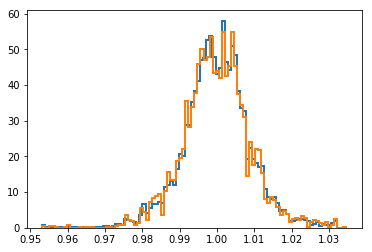

In [22]:
plt.hist(np.hstack(smoothed_flux_dist), bins=100, density=True, lw=2, histtype='step');
plt.hist(np.hstack(baseline_flux_at_flares), bins=100, density=True, lw=2, histtype='step');

In [ ]:
plt.hist(baseline_flux_at_biggest_flare, bins=50);

In [230]:
# np.savetxt('data/morris_amps_fast.txt', 100*np.array([smoothed_amps_fast[i] for i in smoothed_amps_fast]))

Text(0, 0.5, 'stat')

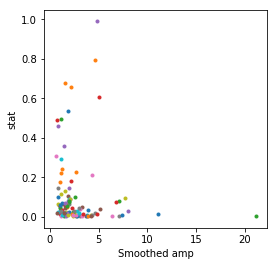

In [277]:
plt.figure(figsize=(4, 4))
for epic in smoothed_amps_fast: 
    plt.scatter(2*douglas.loc[epic]['SmAmp'], newstat_fast[epic], marker='.')
plt.xlabel('Smoothed amp')
plt.ylabel('stat')

In [232]:
# plt.figure(figsize=(4, 4))
# for epic in smoothed_amps_fast: 
#     plt.scatter(2*douglas.loc[epic]['SmAmp'], 100*smoothed_amps_fast[epic], marker='.', color='k')
# plt.xlabel('Douglas et al. (2017)')
# plt.ylabel('This work')
# plt.title('Smoothed amplitude (%)')
# plt.grid()
# plt.savefig('plots/amps_morris_fast.pdf', bbox_inches='tight')

In [239]:
plots = False
smoothed_amps_slow = dict()
newstat_slow = dict()

for i in range(len(slow)): 
    times, fluxes = np.load("data/{0}.npy".format(int(slow[i])))
    if hasattr(times, "__len__"): 
        clipped = ~np.isnan(fluxes)
        clipped &= np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)
        times, fluxes = times[clipped], fluxes[clipped]

        # Remove polynomial trend
        fit = np.polyval(np.polyfit(times-times.mean(), fluxes, 2), times-times.mean())
        fluxes /= fit

        period = douglas.loc[slow[i]]['Prot1']

        phases = (times % period) / period

        sort = np.argsort(phases)
        smoothed = gaussian_filter1d(fluxes[sort], 50, mode='nearest')

        smoothed_amps_slow[slow[i]] = smoothed.max() - smoothed.min()

        fft = np.abs(np.fft.rfft(smoothed))

        newstat_slow[slow[i]] = np.sum(fft)

        if plots: 
            fig, ax = plt.subplots(1, 2, figsize=(10, 3))
            ax[0].plot(times, fluxes)
            ax[1].plot(phases, fluxes, ',', alpha=0.5)
            ax[1].plot(phases[sort], smoothed, 'r')
            ax[1].set_ylim([smoothed.min(), smoothed.max()])


            ax[1].axhline(smoothed.min())
            ax[1].axhline(smoothed.max())
            ax[1].set_title("P = {0} d".format(period))

        plt.show()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


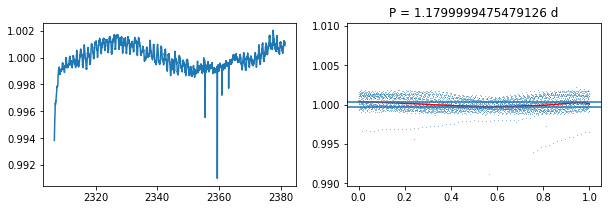

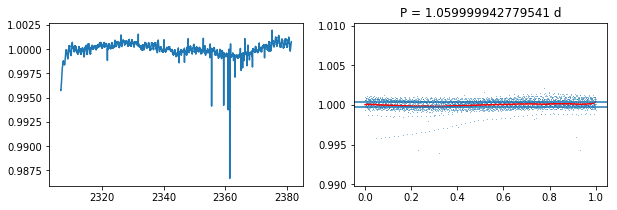

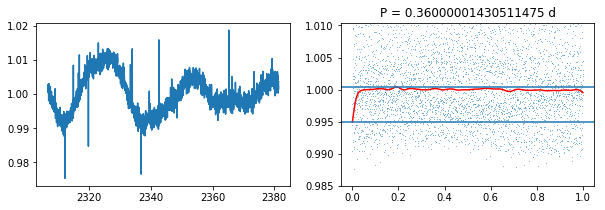

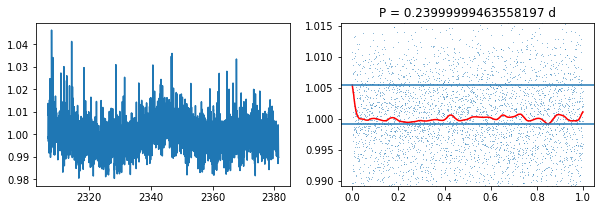

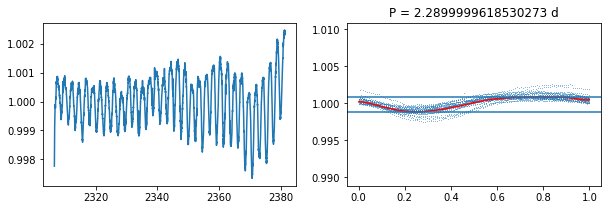

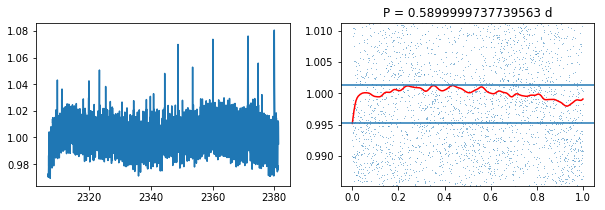

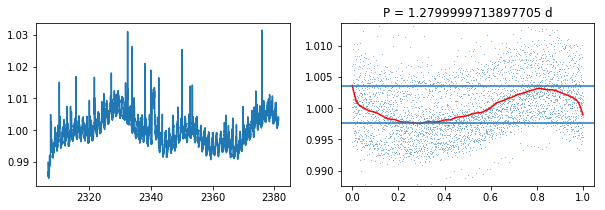

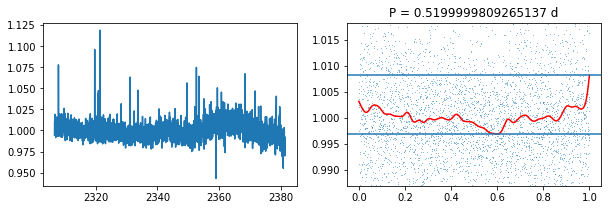

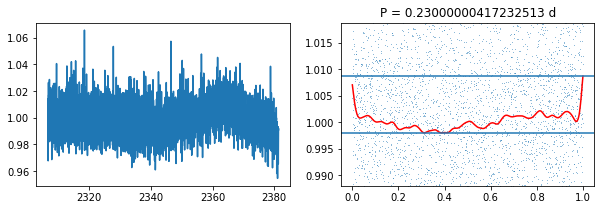

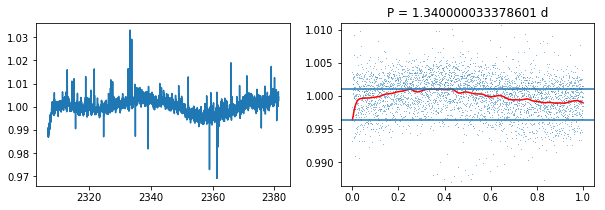

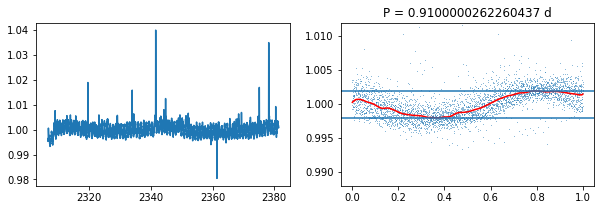

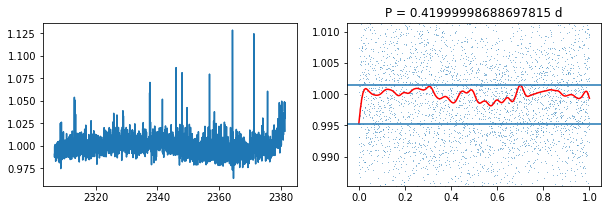

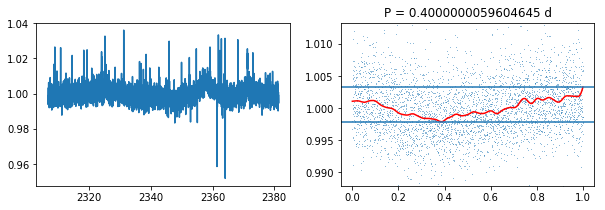

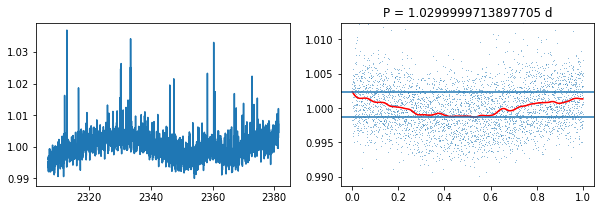

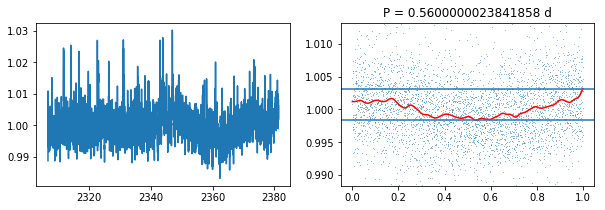

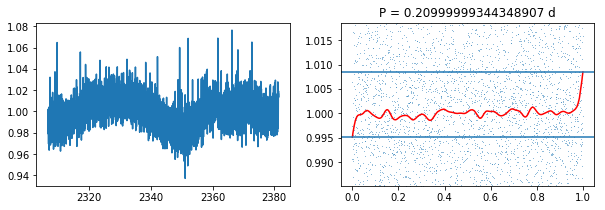

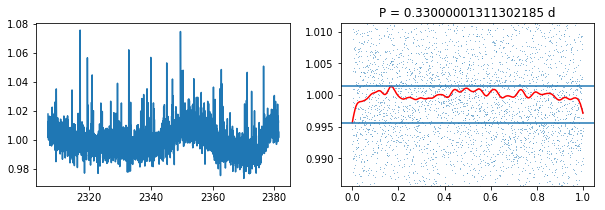

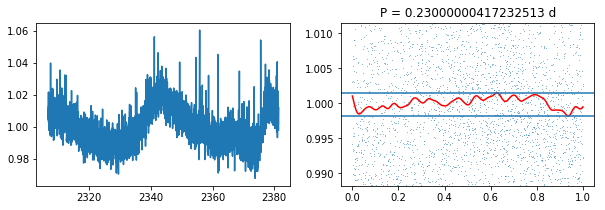

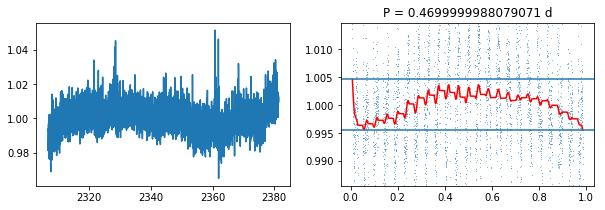

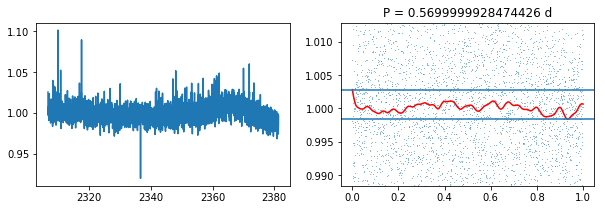

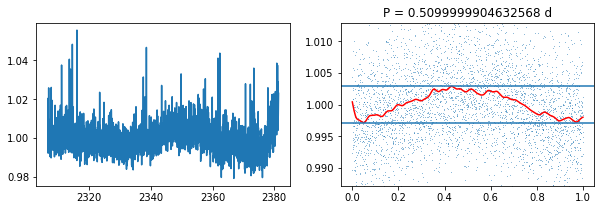

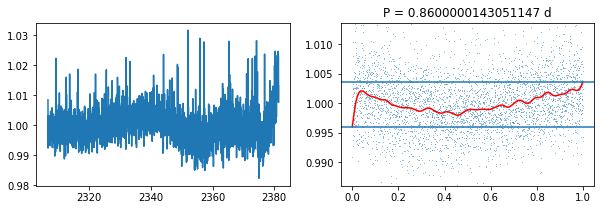

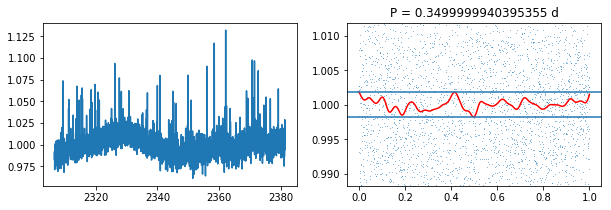

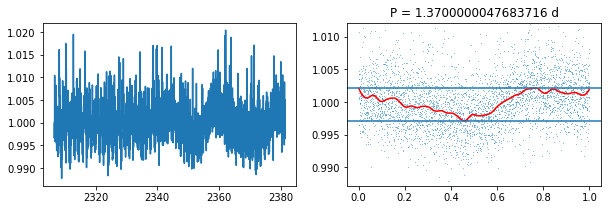

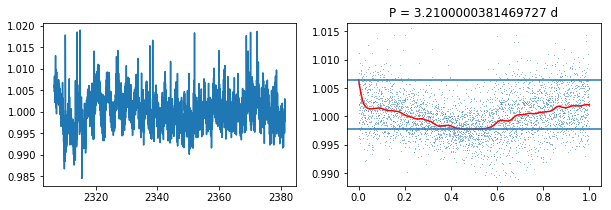

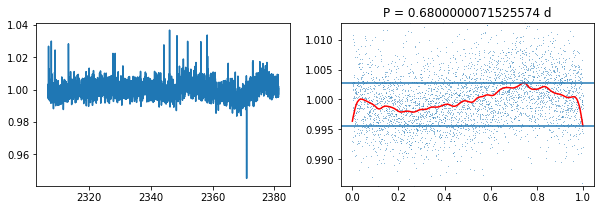

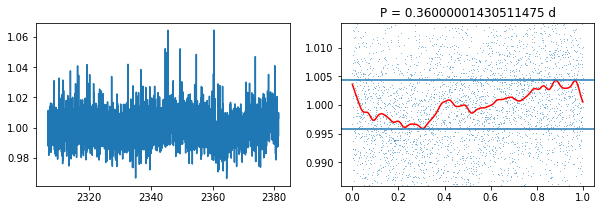

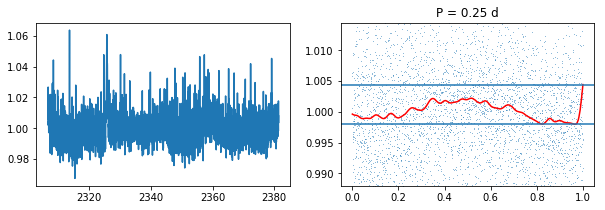

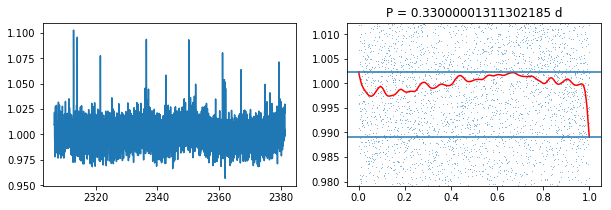

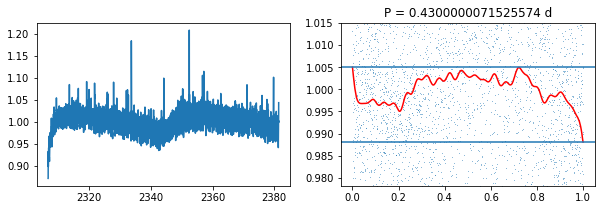

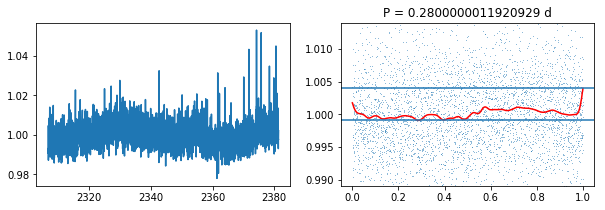

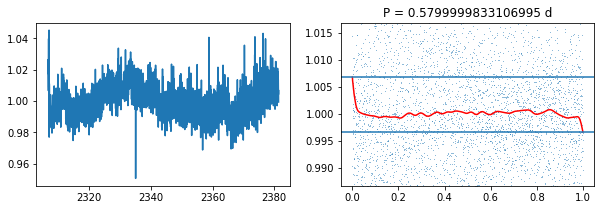

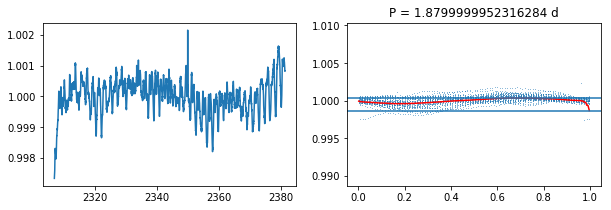

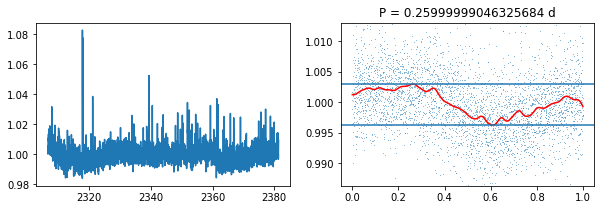

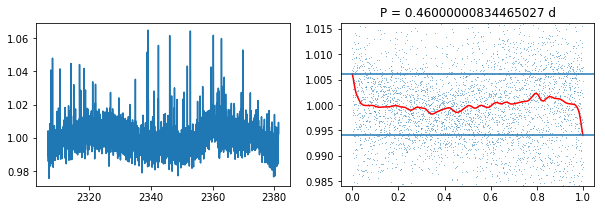

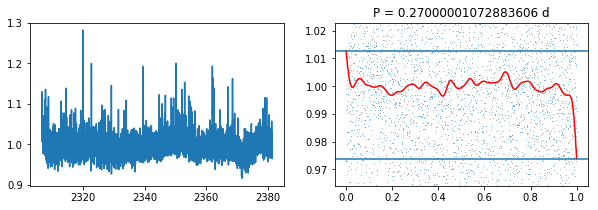

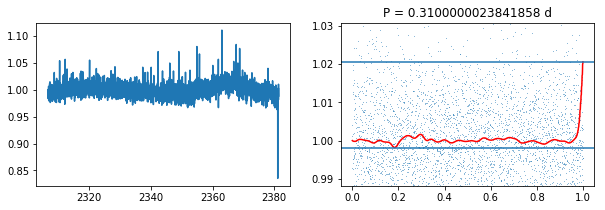

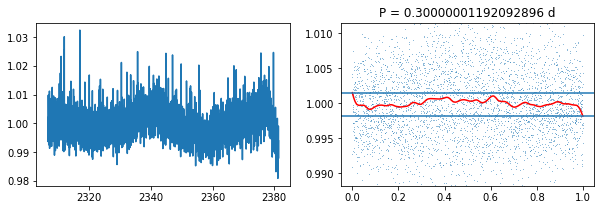

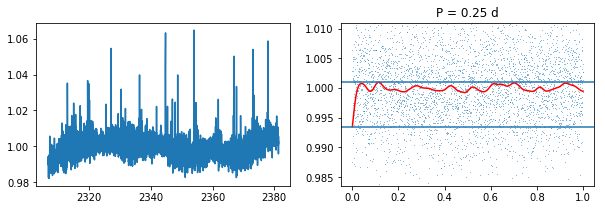

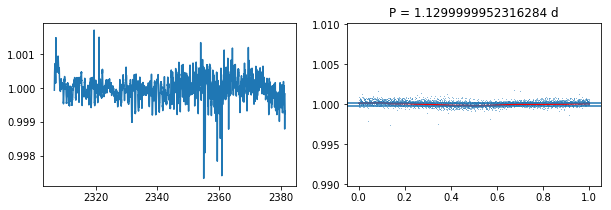

In [28]:
plots = True
smoothed_amps_superfast = dict()
newstat_superfast = dict()

for i in range(len(superfast)): 
    times, fluxes = np.load("data/{0}.npy".format(int(superfast[i])))
    if hasattr(times, "__len__"): 
        clipped = ~np.isnan(fluxes)
        clipped &= np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)
        times, fluxes = times[clipped], fluxes[clipped]

        # Remove polynomial trend
        fit = np.polyval(np.polyfit(times-times.mean(), fluxes, 2), times-times.mean())
        fluxes /= fit

        period = douglas.loc[superfast[i]]['Prot1']

        phases = (times % period) / period

        sort = np.argsort(phases)
        smoothed = gaussian_filter1d(fluxes[sort], 50, mode='nearest')

        smoothed_amps_superfast[superfast[i]] = smoothed.max() - smoothed.min()

        fft = np.abs(np.fft.rfft(smoothed))

        newstat_superfast[superfast[i]] = np.sum(fft)
        
        if plots: 
            fig, ax = plt.subplots(1, 2, figsize=(10, 3))
            ax[0].plot(times, fluxes)
            ax[1].plot(phases, fluxes, ',', alpha=0.5)
            ax[1].plot(phases[sort], smoothed, 'r')
            ax[1].set_ylim([0.99*smoothed.min(), 1.01*smoothed.max()])


            ax[1].axhline(smoothed.min())
            ax[1].axhline(smoothed.max())
            ax[1].set_title("P = {0} d".format(period))

        plt.show()

NameError: name 'newstat_slow' is not defined

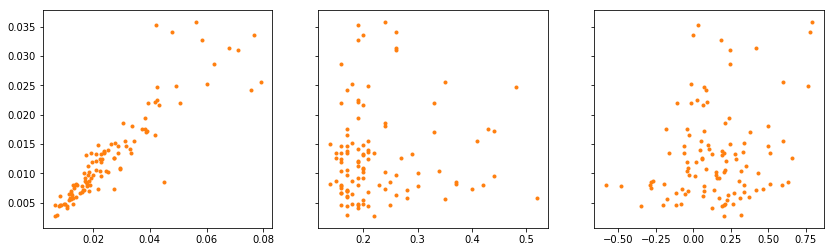

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for epic in newstat_fast: 
    ax[0].scatter(smoothed_amps_fast[epic], newstat_fast[epic], marker='.', color='C1')
    ax[1].scatter(douglas.loc[epic]['Mass'], newstat_fast[epic], marker='.', color='C1')
    ax[2].scatter(np.log10(douglas.loc[epic]['Prot1']), newstat_fast[epic], marker='.', color='C1')

for epic in newstat_slow: 
    ax[0].scatter(smoothed_amps_slow[epic], newstat_slow[epic], marker='.', color='C0')
    ax[1].scatter(douglas.loc[epic]['Mass'], newstat_slow[epic], marker='.', color='C0')
    ax[2].scatter(np.log10(douglas.loc[epic]['Prot1']), newstat_slow[epic], marker='.', color='C0')

for epic in newstat_superfast: 
    ax[0].scatter(smoothed_amps_superfast[epic], newstat_superfast[epic], marker='.', color='C2')
    ax[1].scatter(douglas.loc[epic]['Mass'], newstat_superfast[epic], marker='.', color='C2')
    ax[2].scatter(np.log10(douglas.loc[epic]['Prot1']), newstat_superfast[epic], marker='.', color='C2')

ax[0].set_xlabel('Smoothed amp')
ax[0].set_ylabel('new stat')
ax[1].set_xlabel('mass')
ax[2].set_xlabel('log period')

In [228]:
np.save('data/newstat_slow.npy', newstat_slow)
np.save('data/newstat_fast.npy', newstat_fast)
np.save('data/newstat_superfast.npy', newstat_superfast)

In [114]:
np.savetxt('data/morris_amps_slow.txt', 100*np.array([smoothed_amps_slow[i] for i in smoothed_amps_slow]))

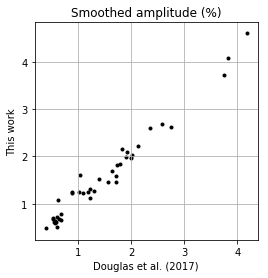

In [113]:
plt.figure(figsize=(4, 4))
for epic in smoothed_amps_slow: 
    plt.scatter(2*douglas.loc[int(epic)]['SmAmp'], 100*smoothed_amps_slow[epic], marker='.', color='k')
plt.grid()
plt.xlabel('Douglas et al. (2017)')
plt.ylabel('This work')
plt.title('Smoothed amplitude (%)')
plt.savefig('plots/amps_morris_slow.pdf', bbox_inches='tight')

In [109]:
len(smoothed_amps_slow), len(smoothed_amps_fast)

(41, 35)